### АА - тест на пользователях из 2 и 3 группы с 2023-01-24 по 2023-01-24. 
### Необходимо удостовериться, что значимых различий между группами нет

In [3]:
import os
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats


import warnings
warnings.filterwarnings("ignore")

In [11]:
# Данные для подключения к БД кликхаус. Логин и пароль спрятаны в окружении репозитория git

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':os.environ.get("DB_LOGIN"),
                      'password':os.environ.get("DB_PASS")
             }

In [225]:
# Для проведения АА теста выгружаю из clickhouse пользователей из 2 и 3 группы с 2023-01-24 по 2023-01-24.

query = '''
SELECT user_id, exp_group, toDate(time) as date,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-24' and '2023-01-30' 
AND exp_group in (2, 3)
GROUP BY user_id, exp_group, date
'''

df = ph.read_clickhouse(query, connection=connection)

Убедимся, что группы поделены примерно в равных пропорциях

In [58]:
print ('Размер группы 2: {}% \nРазмер группы 3: {}%'
       .format(round(df.groupby('exp_group').user_id.count()[2] / len(df), 3) *100, 
               round(df.groupby('exp_group').user_id.count()[3] / len(df), 3) *100))
       

Размер группы 2: 49.5% 
Размер группы 3: 50.5%


Взглянем на распределение CTR в группах:

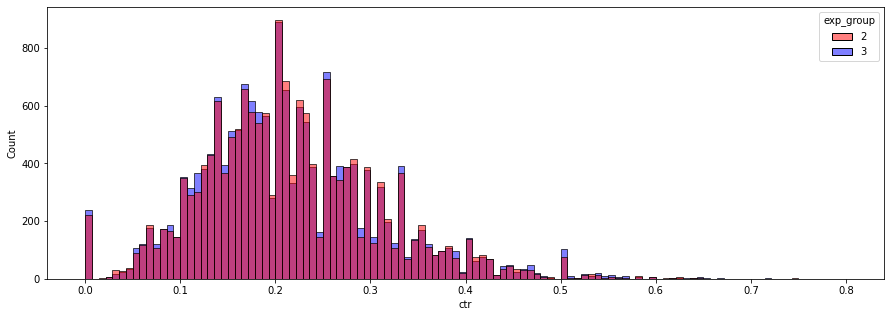

In [224]:
plt.figure(figsize=(15,5))
sns.histplot(df, x='ctr', hue= 'exp_group', palette=['red', 'blue'], legend=True);

In [268]:
# Записываю результаты 10000 испытаний на выборках по 500 юзеров в список

p_values = []
for i in range (10000):   
    stat, p_v = ttest_ind(np.random.choice(df[df['exp_group'] == 2].ctr, 500, replace=False),
                          np.random.choice(df[df['exp_group'] == 3].ctr, 500, replace=False))
    p_values.append(p_v)

In [290]:
# Для удобства данные заношу в датафрейм

res = pd.DataFrame(p_values, columns=['p_values'])

### 1. Построить гистограмму распределения получившихся 10000 p-values.

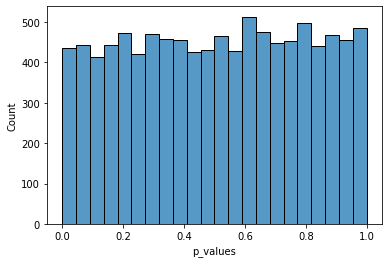

In [294]:
sns.histplot(res.p_values);

### 2. Посчитать, какой процент p values оказался меньше либо равен 0.05

In [295]:
print (f'Доля pvalue <= 0.05: {res[res.p_values <= 0.05].shape[0] *100.0 / len(res)}%')

Доля pvalue <= 0.05: 4.75%


### 3. Вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Примерно 5% ttest показали на выборках статистически значимые различия (если alpha = 0.05) в двух группах. Сплиттование работает корректно.